# Setup

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
tf.version.VERSION

'2.4.0'

Hierarchical Normal Example Model

$$
\begin{align}
x_n &\sim p(x | \theta_l, \sigma^2) \text{ for } n=1,...,N \text { (assume } \sigma^2 \text { to be known (=1))}\\
\theta_l &\sim p(\theta | \mu, \tau^2) \text{ for } l=1,...,L\\
\mu &\sim p(\mu | \mu_0, \tau_0)\\
\tau^2 &\sim p(\tau^2 | \alpha, \beta)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }H_0 \text{: } \mu=0\\
&\text{Alternative Model }H_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Simulator class

In [4]:
class HierarchicalNormalSimulator:
    
    def __init__(self):    
        pass
    
    def draw_from_prior(self, model_index, n_clusters, mu0, tau20, alpha, beta):
        """
        Draws parameter values from the specified prior distributions of the 
        hyperprior and the conditional prior.
        ----------
        
        Arguments:        
        n_clusters : int -- number of higher order clusters that the observations are nested in
        mu0        : float -- higher order mean prior - mean
        tau20      : float -- higher order mean prior - variance
        alpha      : float -- higher order variance prior - shape parameter
        beta       : float -- higher order variance prior - rate parameter
        """
        
        if model_index == 0: 
            mu = 0 # must be mu=0 // mu=100 for quick model convergence checks
        if model_index == 1:
            mu = np.random.normal(loc=mu0, scale=np.sqrt(tau20))
            
        tau2 = 1/np.random.gamma(alpha, beta)
        theta = np.random.normal(loc=mu, scale=np.sqrt(tau2), size=n_clusters)
        return theta
    
    def gen_from_likelihood(self, theta, n_obs):
        """
        Generates a single hierarchical dataset from the sampled parameter values.
        ----------
        
        Arguments: 
        params : list -- parameters sampled from prior 
        n_obs  : int -- number of observations per cluster
        """
        
        X = np.random.normal(loc=theta, scale=1, size=(n_obs, theta.shape[0])).T 
        return X
    
    def generate_single(self, model_index, n_clusters, n_obs, mu0=0, tau20=1, alpha=1, beta=1):
        """
        Generates a single hierarchical dataset.
        ----------
        
        Arguments:
        model_index    : int -- index of the model to be simulated from
        n_clusters     : int -- number of higher order clusters that the observations are nested in
        n_obs          : int -- number of observations per cluster
        mu0            : float -- higher order mean prior - mean
        tau20          : float -- higher order mean prior - variance
        alpha          : float -- higher order variance prior - shape parameter
        beta           : float -- higher order variance prior - rate parameter
        --------
        
        Returns:
        numpy array of shape (n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        prior_sample = self.draw_from_prior(model_index, n_clusters, mu0, tau20, alpha, beta)
        x_generated = self.gen_from_likelihood(prior_sample, n_obs)
        return x_generated[...,np.newaxis]
        
    
    def simulate(self, batch_size, n_models, n_clusters, n_obs, mu0=0, tau20=1, alpha=1, beta=1):
        """
        Simulates multiple hierarchical datasets. Useful for single usage and debugging (both without the MainSimulator).
        ----------
        
        Arguments:
        batch_size     : int -- number of batches to be generated
        n_models       : int -- number of models to be simulated from
        n_clusters     : int -- number of higher order clusters that the observations are nested in
        n_obs          : int -- number of observations per cluster
        n_variables    : int -- number of variables in the simulated datasets 
        mu0            : float -- higher order mean prior - mean
        tau20          : float -- higher order mean prior - variance
        alpha          : float -- higher order variance prior - shape parameter
        beta           : float -- higher order variance prior - rate parameter
        --------
        
        Returns:
        numpy array of shape (batch_size * n_models, n_clusters, n_obs, n_variables) - contains the simulated hierarchical datasets
        """
        
        X = []
        for b in range(batch_size):
            prior_sample = self.draw_from_prior(n_clusters, mu0, tau20, alpha, beta)
            x_generated = self.gen_from_likelihood(prior_sample, n_obs)
            X.append(x_generated)
        return np.array(X)[...,np.newaxis]

In [5]:
class MainSimulator:
    
    def __init__(self, simulator):
        
        self.simulator = simulator
    
    def draw_from_model_prior(self, batch_size, n_models, model_prior):
        """
        Creates the sequence of models to be simulated from in the batch.
        ----------
        
        Arguments:
        batch_size     : int -- number of batches to be generated
        n_models       : int -- number of models to be simulated from
        model_prior    : list -- prior model probabilities
        --------
        
        Returns:
        array of shape (batch_size) - array of indices corresponding to the sampled model from p(M).
        """
        
        # create base list of model indices
        model_base_indices = [*range(n_models)]
        
        # uniform prior over model probabilities if no model prior given
        if model_prior == None:
            model_prior = [1/n_models] * n_models
        
        # generate sampling list of model indeces
        model_indices = np.random.choice(model_base_indices, size=batch_size, p=model_prior)
        return model_indices
    
    def simulate(self, batch_size, n_models, model_prior, n_clust_min=2, n_clust_max=100, n_obs_min=2, n_obs_max=200):
        """
        Simulates a batch of hierarchical datasets.
        ----------
        
        Arguments:
        batch_size     : int -- number of datasets to be generated per batch
        n_models       : int -- number of models to be simulated from
        model_prior    : list -- prior model probabilities
        n_clust_min    : int -- minimum number of clusters
        n_clust_max    : int -- maximum number of cluster
        n_obs_min      : int -- minimum number of observations
        n_obs_max      : int -- maximum number of observations
        --------
        
        Returns:
        dict of {'X' : array of shape (batch_size, n_clusters, n_obs, n_variables),  
                 'm' : array of shape (batch_size)}
        """
        # Draw K and N (equal for all datasets in the batch)
        n_clusters = np.random.randint(n_clust_min, n_clust_max+1)
        n_obs = np.random.randint(n_obs_min, n_obs_max+1)
        
        # Draw sampling list of model indices
        model_indices = self.draw_from_model_prior(batch_size, n_models, model_prior)
        
        # Prepare an array to hold simulations
        X_gen = np.zeros((batch_size, n_clusters, n_obs, 1), dtype=np.float32)
        
        for b in range(batch_size):
            X_gen[b] = self.simulator.generate_single(model_indices[b], n_clusters, n_obs)
               
        return {'X': X_gen, 'm': model_indices}
    
    def __call__(self, batch_size, n_models=2, model_prior=None, n_clust_min=2, n_clust_max=100, n_obs_min=2, n_obs_max=200):
        return self.simulate(batch_size, n_models, model_prior, n_clust_min, n_clust_max, n_obs_min, n_obs_max)

In [6]:
# Construct simulator

main_sim = MainSimulator(HierarchicalNormalSimulator())

In [7]:
%%time
# Testing zone: how do shapes and index distribution change in different runs?

print(main_sim(64)["X"][:, 0, :, :].shape) # shape of 1 cluster 
print(np.unique(main_sim(64)["m"], return_counts=True)[1]) # model index distribution in batch

(64, 173, 1)
[34 30]
Wall time: 26.4 ms


In [8]:
%%time
# Simulate a batch for subsequent NN development

simulated_batch = main_sim(2)
print(simulated_batch["X"].shape)
print(simulated_batch["X"][0,:2,:3,:]) # display the first 3 observations of the first 2 clusters of the first batch

(2, 53, 99, 1)
[[[ 0.07444806]
  [-1.8053213 ]
  [-0.87056285]]

 [[ 0.96316373]
  [ 2.9117162 ]
  [ 0.54146653]]]
Wall time: 1 ms


# Network Class

Structure:
- Invariant Layer Class
- Equivariant Layer Class
- Hierarchical Invariant Network Class (Equivar. + Invar.)
- Deep Hierarchical Evidential Model Class (multiple Hier.Inv.Netw.)

To do:
- Invariant module:
- Equivariant module:
    - call() Description of arguments and return
    
- setting dictionary, no units invariant module 

In [9]:
# DELETE; LEGACY

# Settings

# DICTIONARY ERSTELLEN, siehe BayesFlow

n_dense_inv = 2 # no of layers pre pooling in the invariant network
n_dense_post = 2 # no of layers post pooling in the invariant network
n_dense_equiv = 2 # no of layers in the equivariant network
n_equiv = 2 # no of equivariant modules to be stacked



## Settings

In [10]:
model_settings = {
    'n_models'                    : 2,
    'dense_inv_pre_pooling_args'  : dict(units=4, activation='elu', kernel_initializer='glorot_normal'),
    'dense_inv_post_pooling_args' : dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
    'dense_equiv_args'            : dict(units=32, activation='elu', kernel_initializer='glorot_normal'),
    'n_dense_inv'                 : 2,
    'n_dense_equiv'               : 2
}

## Invariant Module

In [11]:
class InvariantModule(tf.keras.Model):
    """Implements an invariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, model_settings):
        """
        Creates an invariant function with mean pooling.
        ----------
        
        Arguments:
        model_settings : dict -- hyperparameter settings for the invariant module
        """
        
        super(InvariantModule, self).__init__()
        
        # Pre pooling network
        self.pre_pooling_dense = tf.keras.Sequential([tf.keras.layers.Dense(**model_settings['dense_inv_pre_pooling_args'])
                                           for _ in range(model_settings['n_dense_inv'])])
        
        # Initialize weights
        self.weights_layer = None
        
        # Post pooling network
        self.post_pooling_dense = tf.keras.Sequential([tf.keras.layers.Dense(**model_settings['dense_inv_post_pooling_args'])
                                                      for _ in range(model_settings['n_dense_inv'])])
        
            
    def call(self, x):
        """
        Transforms the input into an invariant representation.
        ----------
        
        Arguments:
        x : tf.Tensor of variable shape - either 4-dimensional with (batch_size, n_clusters, n_obs, n_variables)
                                          or 3-dimensional with (batch_size, n_clusters, inv_embedding)
        --------
        
        Returns:
        out: tf.Tensor of variable shape - either 3-dimensional (when input is 4D) with (batch_size, n_clusters, inv_embedding)
                                           or 2-dimensional (when input is 3D) with (batch_size, inv_embedding)
        """
        
        # Embed input
        x_emb = self.pre_pooling_dense(x)
        
        # Perform mean pooling
        w_x = tf.reduce_mean(x_emb, axis=-2) # always reduce dimensionality of the lowest exchangable data level 
        
        # Increase representational power
        out = self.post_pooling_dense(w_x)
        return out

In [12]:
# Initialize Invariant Nets before testing

inv = InvariantModule(model_settings)
inv2 = InvariantModule(model_settings)

In [13]:
# Test if dimensionality reduction of invariant module works

simulated_batch = main_sim(2)

print('{} - Shape of the simulated batch of data'.format(simulated_batch["X"].shape))

reduce_to_3D = inv(x=simulated_batch["X"])
print('{} - Shape of the first invariant module output'.format(reduce_to_3D.shape))

reduce_to_2D = inv2(reduce_to_3D)
print('{} - Shape of the second invariant module output'.format(reduce_to_2D.shape))

(2, 71, 85, 1) - Shape of the simulated batch of data
(2, 71, 64) - Shape of the first invariant module output
(2, 64) - Shape of the second invariant module output


### Invariant Net Classifier Experiment

#### Hierarchical Network Class 

In [14]:
class HierarchicalNetwork(tf.keras.Model):
    """
    Implements a network that can process hierarchical data.
    """
    
    def __init__(self, model_settings):
        """
        Creates a hierarchical Network consisting of two stacked invariant modules.
        ----------
        
        Arguments:
        model_settings : dict -- hyperparameter settings for the invariant module
        """
        
        super(HierarchicalNetwork, self).__init__()
        
        self.inv_4d = InvariantModule(model_settings)
        self.inv_3d = InvariantModule(model_settings)
        
        # The final layer to output model evidences
        if model_settings['n_models'] == 2: # Binary Classification
            n_out = 1 
            act_out = "sigmoid"
        else:
            n_out = model_settings['n_models']
            act_out = "softmax"
        self.model_probs_layer = tf.keras.layers.Dense(n_out, activation=act_out)
        
        
    def call(self, x):
        """
        Transforms the 4-dimensional input into model probabilities.
        ----------
        
        Arguments:
        x : tf.Tensor of shape (batch_size, n_clusters, n_obs, n_variables)
        --------
        
        Returns:
        model_probs : tf.Tensor of shape (batch_size, n_models) -- the model posterior probabilities
        """
        
        x_3d = self.inv_4d(x)
        x_2d = self.inv_3d(x_3d)
        model_probs = self.model_probs_layer(x_2d)
        
        return model_probs

#### Training 

In [15]:
from functools import partial

In [36]:
# Training Settings

model = HierarchicalNetwork(model_settings)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
batch_size = 32
simulator = partial(MainSimulator(HierarchicalNormalSimulator()), batch_size)
loss_fun = tf.losses.BinaryCrossentropy()
iterations = 1000
epochs = 10

In [37]:
def train_online(model, optimizer, simulator, loss_fun, iterations, batch_size, epochs):
    """
    Trains a Hierarchical Network.
    ----------
        
    Arguments:
    ... TO DO
    --------
        
    Returns:
    losses : numpy array of shape (iterations * epochs)
    """
    
    losses = []
    
    # For loop through epochs
    for ep in range(1, epochs+1):
        for it in range(1, iterations+1):
            
            # Simulate batch of datasets
            batch = simulator()
            
            with tf.GradientTape() as tape:
                
                # Forward pass
                outputs = model(batch["X"])[:,0] # [:,0] to match shape of predictions with true indices
                
                batch_m = batch["m"]
                
                loss = loss_fun(batch_m, outputs)
                
            # One step backprop
            gradients = tape.gradient(loss, model.trainable_variables)
            
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Store losses
            losses.append(loss)
    
    return losses

In [38]:
%%time

# train model
losses = train_online(model, optimizer, simulator, loss_fun, iterations, batch_size, epochs)

Wall time: 3min 11s


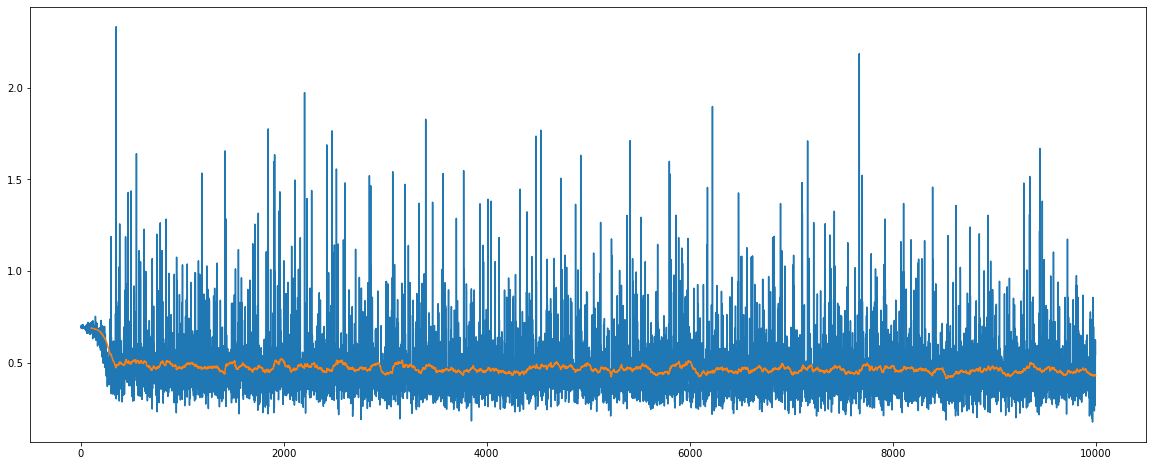

In [75]:
# calculate rolling average of losses to get a trend line
import pandas as pd

losses_rolling = pd.DataFrame(losses)
losses_rolling = losses_rolling.rolling(window=100).mean()

# plot losses
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,8)
plt.plot(losses)
plt.plot(losses_rolling) # add trend line

#### Apply to data and evaluate results

In [44]:
# Test how predictions look like

# Simulate test data
main_sim = MainSimulator(HierarchicalNormalSimulator())
test_data = main_sim(1000)
true_indices = test_data["m"]

# Predict
predictions_for_model1 = model.predict(test_data["X"])[:,0]  # [:,0] to match shape of predictions with true_indices
prediction_labels_for_model1 = np.round(predictions_for_model1)

# Mean absolute error
mae = abs(true_indices-predictions_for_model1).mean()
print('Mean absolute error: {}'.format(mae))

# Accuracy
accuracy = (prediction_labels_for_model1 == true_indices).mean()
print('Accuracy: {}'.format(accuracy))

Mean absolute error: 0.3537650787755847
Accuracy: 0.677


Text(0, 0.5, 'Model confidence')

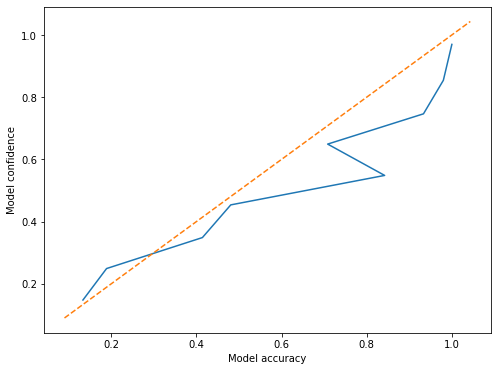

In [41]:
# Calibration curve

from sklearn.calibration import calibration_curve

f, ax = plt.subplots(figsize=(8,6))
prob_true, prob_pred = calibration_curve(test_data["m"], predictions_for_model1, n_bins=10)
ax.plot(prob_true, prob_pred)
ax.plot(ax.get_xlim(), ax.get_xlim(), '--')
ax.set_xlabel('Model accuracy')
ax.set_ylabel('Model confidence')

### Invariant Module Testing

In [22]:
# Generate test data
main_sim = MainSimulator(HierarchicalNormalSimulator())
test_data = main_sim(1)

# Setup 
rng = np.random.default_rng()
preds_unpermuted = model.predict(test_data["X"])

# Permute & predict observations within clusters
test_data_obs_perm = rng.permutation(test_data["X"], axis = 2)
preds_obs_perm = model.predict(test_data_obs_perm)

# Permute & predict clusters
test_data_clust_perm = rng.permutation(test_data["X"], axis = 1)
preds_clust_perm = model.predict(test_data_clust_perm)

# Assert equivalence
assert preds_unpermuted.all() == preds_obs_perm.all(),\
'The network is behaving differently when the observations are permuted!'

assert preds_unpermuted.all() == preds_clust_perm.all(),\
'The network is behaving differently when the clusters are permuted!'

In [23]:
# Permutation check

# Obs
print('Should be equal, only obs were shuffled:')
print(test_data["X"][0,0,:,:].mean())
print(test_data_obs_perm[0,0,:,:].mean())

# Clusters
print('Should be equal, only clusters were shuffled:')
print(test_data["X"][0,:,:,:].mean())
print(test_data_clust_perm[0,:,:,:].mean())
print('Should not be equal, clusters should have changed positions:')
print(test_data["X"][0,0,:,:].mean())
print(test_data_clust_perm[0,0,:,:].mean())

Should be equal, only obs were shuffled:
-0.79952705
-0.79952705
Should be equal, only clusters were shuffled:
-1.0192314
-1.0192314
Should not be equal, clusters should have changed positions:
-0.79952705
-0.9027621


## Equivariant Module

In [25]:
class EquivariantModule(tf.keras.Model):
    """Implements an equivariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, model_settings):
        """
        Creates an equivariant neural network consisting of a FC network with
        equal number of hidden units in each layer and an invariant module
        with the same FC structure.
        ----------
        
        Arguments:
        n_dense_equiv : int -- no of layers in the equivariant network
        """
        
        super(EquivariantModule,self).__init__()
        
        # Equivariant Network
        self.module = tf.keras.Sequential([tf.keras.layers.Dense(**model_settings['dense_equiv_args'])
                                           for _ in range(model_settings['n_dense_equiv'])])
        
        self.invariant_module = InvariantModule(model_settings)
        
    def call (self, x):
        """
        Transforms the input into an equivariant representation.
        ----------
        
        Arguments:
        x : tf.Tensor of shape ???
        --------
        
        Returns:
        out: tf.Tensor of shape ???
        """
        
        # Run input through invariant network 
        x_inv = self.invariant_module(x)
        
        # Repeat x_inv n times so that it matches x
        # read out position -2 so that the layer to be permuted is accessed in 3D as well as 4D
        x_inv = tf.stack([x_inv] * int(x.shape[-2]), axis=-2)
        
        # Concat original input with invariant transformation
        x = tf.concat((x_inv, x), axis=-1)
        
        # Run through equivariant network
        out = self.module(x)
        
        return out

In [26]:
# Initialize Equivariant Nets before testing

equiv = EquivariantModule(model_settings)
equiv2 = EquivariantModule(model_settings)

In [27]:
# Test if equivariant transformation of equivariant module works

simulated_batch = main_sim(2)

print('{} - Shape of the simulated batch of data'.format(simulated_batch["X"].shape))

# test with 4D data
x_equiv4D = equiv(x=simulated_batch["X"])
print('{} - Shape of the equivariant module output in 4D'.format(x_equiv4D.shape))

# test with 3D data
x_equiv3D = equiv2(x=reduce_to_3D)
print('{} - Shape of the equivariant module output in 3D'.format(x_equiv3D.shape))

(2, 24, 179, 1) - Shape of the simulated batch of data
(2, 24, 179, 32) - Shape of the equivariant module output in 4D
(2, 71, 32) - Shape of the equivariant module output in 3D


In [28]:
# Test if the invariant module can handle the output of the equivariant module

inv = InvariantModule(model_settings)
inv_with_equiv_input = inv(x_equiv4D)
print('{} - Shape of the invariant module output when given the 4D-output of the equivariant module'.format(inv_with_equiv_input.shape))

(2, 24, 64) - Shape of the invariant module output when given the 4D-output of the equivariant module


In [29]:
# Test if multiple equivariant modules are stackable

equiv = EquivariantModule(model_settings)
equiv3 = equiv(x=x_equiv4D)
print('{} - Shape of the equivariant module output when given the 4D-output of the equivariant module'.format(x_equiv4D.shape))

(2, 24, 179, 32) - Shape of the equivariant module output when given the 4D-output of the equivariant module


## Bridge Sampling Comparison - Bayes Factor Approximation

In [102]:
np.random.seed(42)

main_sim = MainSimulator(HierarchicalNormalSimulator())

test_data_bf = main_sim(2)
test_data_bf_true_indices = test_data_bf["m"]
test_data_bf = test_data_bf["X"]
test_data_bf.shape

(2, 53, 94, 1)

In [103]:
test_data_bf_true_indices

array([0, 1])

In [93]:
np.save('test_data_bf', test_data_bf)